In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

 99% 801M/812M [00:08<00:00, 41.9MB/s]
100% 812M/812M [00:08<00:00, 104MB/s] 


In [4]:
import os, shutil, pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.utils import image_dataset_from_directory

In [5]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [6]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

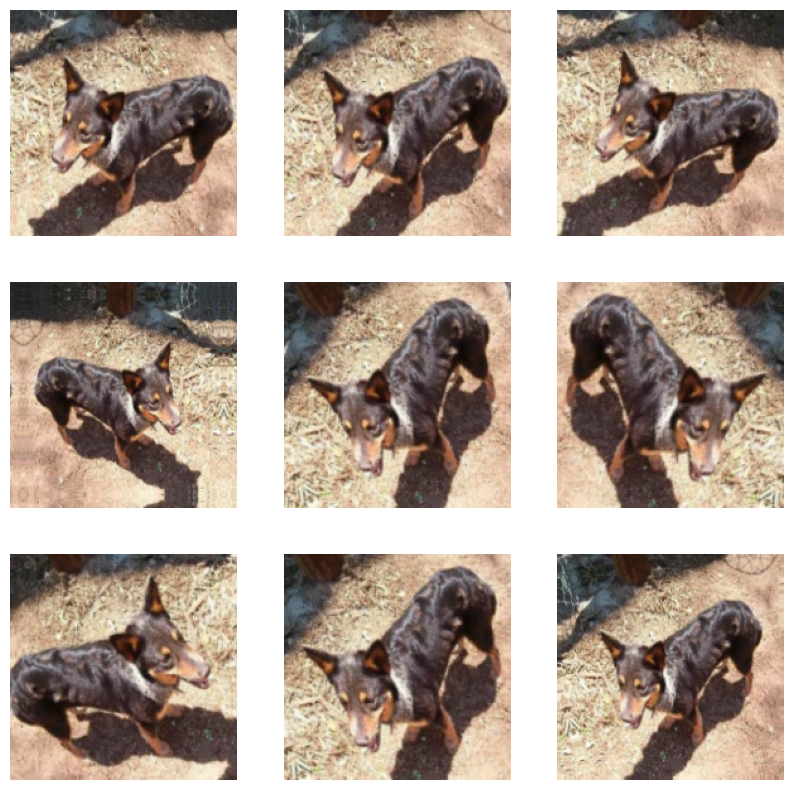

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.tf",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 21s 121ms/step - loss: 0.7071 - accuracy: 0.5090 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 8s 116ms/step - loss: 0.6941 - accuracy: 0.5035 - val_loss: 0.6912 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 5s 84ms/step - loss: 0.6926 - accuracy: 0.5535 - val_loss: 0.6763 - val_accuracy: 0.6120
Epoch 4/100
63/63 [==============================] - 6s 100ms/step - loss: 0.6815 - accuracy: 0.5785 - val_loss: 0.6658 - val_accuracy: 0.6090
Epoch 5/100
63/63 [==============================] - 6s 93ms/step - loss: 0.6611 - accuracy: 0.6225 - val_loss: 0.6415 - val_accuracy: 0.6560
Epoch 6/100
63/63 [==============================] - 6s 89ms/step - loss: 0.6470 - accuracy: 0.6335 - val_loss: 0.6764 - val_accuracy: 0.6000
Epoch 7/100
63/63 [==============================] - 6s 87ms/step - loss: 0.6426 - accuracy: 0.6410 - val_loss: 0.6373 - val_accuracy: 0.6090
Ep

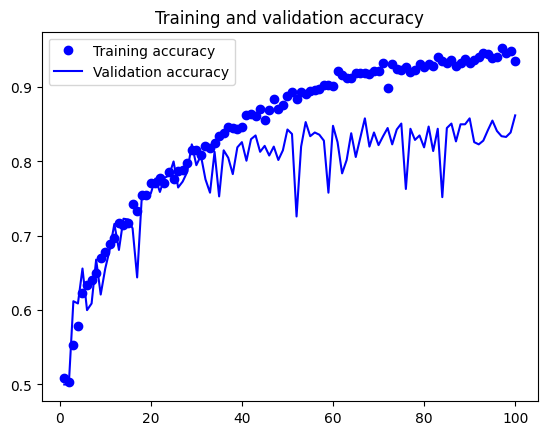

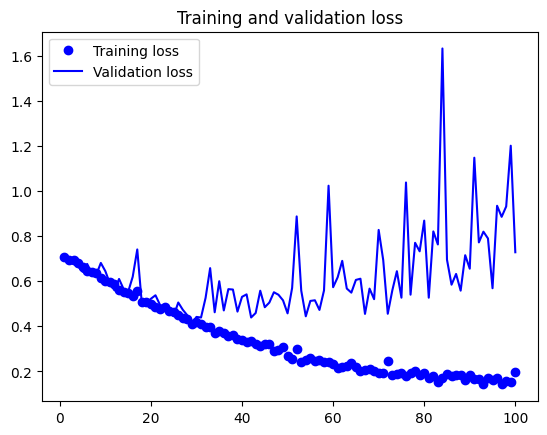

In [11]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [12]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.tf")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 30ms/step - loss: 0.4501 - accuracy: 0.7995
Test accuracy: 0.799


In [13]:
!zip -r /content/convnet_from_scratch_with_augmentation.tf.zip /content/convnet_from_scratch_with_augmentation.tf

  adding: content/convnet_from_scratch_with_augmentation.tf/ (stored 0%)
  adding: content/convnet_from_scratch_with_augmentation.tf/saved_model.pb (deflated 88%)
  adding: content/convnet_from_scratch_with_augmentation.tf/variables/ (stored 0%)
  adding: content/convnet_from_scratch_with_augmentation.tf/variables/variables.index (deflated 63%)
  adding: content/convnet_from_scratch_with_augmentation.tf/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/convnet_from_scratch_with_augmentation.tf/assets/ (stored 0%)
  adding: content/convnet_from_scratch_with_augmentation.tf/keras_metadata.pb (deflated 93%)
  adding: content/convnet_from_scratch_with_augmentation.tf/fingerprint.pb (stored 0%)
